# Давайте проанализируем датасет который мы получили в предыдущем ноутбуке

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [3]:
!no | cp drive/MyDrive/ColabNotebooks/cmf/project2/btc.csv.zip btc.zip

!no | unzip btc.zip

/bin/bash: no: command not found
/bin/bash: no: command not found
Archive:  btc.zip
replace btc.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


##### уберем проблемы в данных

Для курса btc я взял достаточно актуальный датасет с дневными ценами, важно что в нем есть цена открытия и цена закрытия

In [4]:
from datetime import datetime
def check_date(date):
    try:
        datetime.strptime(str(date),'%Y-%m-%d %H:%M:%S')
        return True
    except ValueError as err:
        return False



data = pd.read_csv('drive/MyDrive/ColabNotebooks/cmf/project2/all_bert_all_2epoch.csv')

data = data[data['date'].apply(lambda x: check_date(x))]
data['datetime'] = data['date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
# data['Twit_Timestamp'] = data['date'].astype('int64') // 10**9
# data['datetime'] = data['Twit_Timestamp'].apply(lambda x: datetime.fromtimestamp(x))
# data = data.sort_values('Twit_Timestamp')
# data['id'] = np.arange(len(data))

btc = pd.read_csv('btc.csv', parse_dates=['Date'])
btc = btc.set_index(btc['Date'].dt.date)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Немного посмотрим на данные

Здесь видно даты за которые у нас есть и курс и твиты. курс - оранжевая линия, твиты-синяя. Плохо что пересечение маленькое, причем я подбирал множетсво разных датасетов ситуация всегда остается +- такой же.
<br>
Однако я анализировал большой датасет в котором было много твитов с 2015 года (но на всех языках мира, переводить датасет оч было долго) и могу сказать что в 2019 произошел непонятный бум, твитов в тот год было в 20 раз больше чем за все предыдущие годы вместе взятые, что говорит о том, что предпослыка должна работать примерно с 2019 и ранее среда была другой, значит там и так можно не анализировать

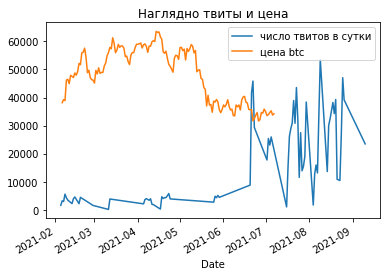

In [5]:
data.groupby(data['datetime'].dt.date).apply(len).plot(label="число твитов в сутки")


start_date = data['datetime'].min()
btc[btc['Date'] > start_date].set_index('Date')['Close'].plot(label="цена btc")
plt.legend(loc="upper right")

plt.title('Наглядно твиты и цена')
plt.show()

Посмотрим интенсивность активности, заодно ранее возникали вопросы к качеству даных

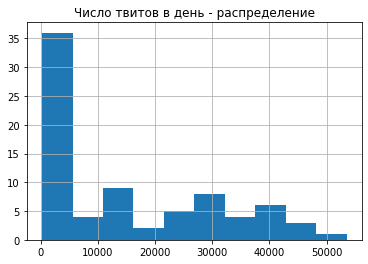

In [6]:
data.groupby(data['datetime'].dt.date)['score'].count().hist()
plt.title('Число твитов в день - распределение')
plt.show()

# Посмотрим как обычно распределены твиты на примере 5 рандомных дней

In [7]:
# scipy.stats.skew

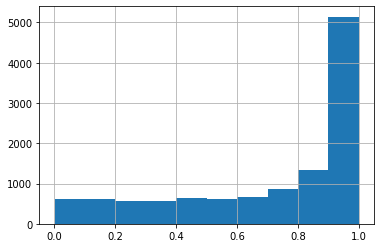

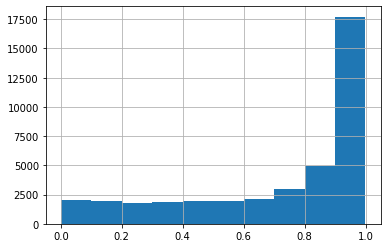

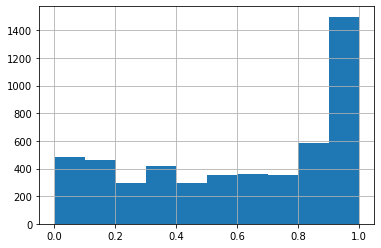

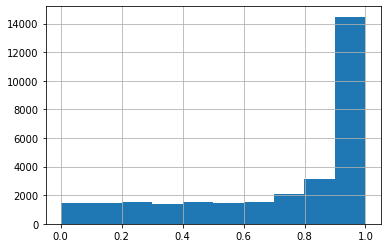

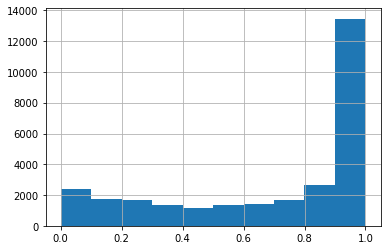

In [8]:
for d in np.random.choice(data['datetime'].dt.date.unique(), 5):
    data[data['datetime'].dt.date == d]['score'].hist()
    plt.show()

# Наша скор новостей - мединное настроение за день. оно просто отражает как говорили вчера люди

In [9]:
# from scipy.stats import skew, kurtosis
# data['h'] = np.sqrt(data['datetime'].dt.hour / 24)

date_score = data.groupby(data['datetime'].dt.date)['score'].median()
# date_score = data.groupby(data['datetime'].dt.date).apply(lambda x: (x['score'] * x['h']).median())

# Сделаем таргет
Таргет - разница в цене открытия след дня и цене закрытия предыдущего
Получен эксперементальным и логическим путем.

Идея была навеяна тем что в момент открытия рынка ценой движут ожидания, ожидания же как я предпологаю складываются из вчерашней новостной повестки

In [10]:
btc['target'] = np.log(btc['Open']) - np.log(btc['Close'].shift())

Сведем все в одну таблицу

In [11]:
tbl = pd.concat([btc['target'], date_score], axis=1)

In [12]:
tbl = tbl[~tbl.isnull().any(axis=1)]
tbl.columns = ['target', 'score']

In [13]:
tbl.head()

,target,score
2021-02-05,0.000148,0.836074
2021-02-06,-0.000155,0.853614
2021-02-07,-0.000403,0.896033
2021-02-08,-0.000427,0.872234
2021-02-09,-0.000248,0.845333


# Посмотрим

In [14]:
len(tbl)

44

#### Табличка получилась маленькая. Как ранее и замечалось датасеты с твитами достаточно плохие, нужно парсить свой. Например ниже дата и точка если наблюдение присутствует, видим непонятные пропуски в данных с твитами

Text(0.5, 1.0, 'Точки где есть цена и твиты')

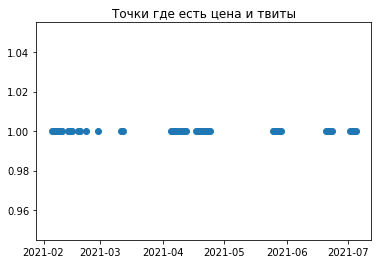

In [15]:
plt.scatter(x=tbl.index.values.tolist(), y=[1] * len(tbl))
plt.title('Точки где есть цена и твиты')

Размер таблички получился так себе, потому что данные о твитах с непонятными пропусками в данных

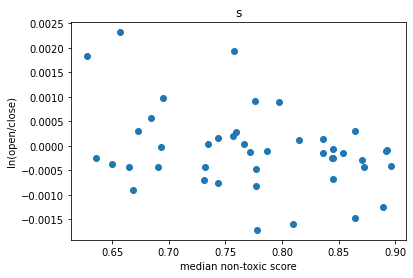

In [16]:
plt.scatter(tbl['score'], tbl['target'])


# plt.xlim(0, 1)
# plt.ylim(-0.001, 0.001)
plt.xlabel('median non-toxic score')
plt.ylabel('ln(open/close)')
plt.title('s')
plt.show()

Замечательно! видна корреляция, но только глазом, но 0.33 все же достаточно для того чтобы капать глубже

In [17]:
np.corrcoef(tbl['score'], tbl['target'])

array([[ 1.        , -0.33526606],
       [-0.33526606,  1.        ]])

In [18]:
from scipy.stats import pearsonr
pearsonr(tbl['score'], tbl['target'])[1]

0.02610091136314166

P_value теста Пирсона 0.026, значит мы не можем отклонить гипотезу о независимости

Так же есть ощущение что есть два облака, одно 'поперечное' и одно 'продольное' сверху вниз по углом, конечно продольное говорит о том что наша фича не работает, но под лекгим углом дает надежду.


# Model